In [1]:
from sandbox.multiplex_network import MultiplexNetwork, GowerSimilarity
import pandas as pd

In [2]:
df = pd.read_csv("..\output\\results.csv")
df = df.iloc[df["BibliotecaNombre"].drop_duplicates(keep="first").index]
df.drop(labels=["tieneComputador", "tieneConectividad"], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,BibliotecaID,BibliotecaNombre,infraestructura_tecnologica,catalogo_digitalización,porcentaje_coleccion_catalogada,nivel_detalle_catalogo,sistemas_clasificacion,nivel_detalle_organizacion_coleccion,tiempo_busqueda_libro,sistema_registro_usuarios,...,sistematización_prestamo_externo,tipos_coleccion,diversidad_colecciones,cantidad_inventario,percepcion_estado_colecciones,enfoques_colecciones,num_enfoques,actividades_mediacion,frecuencia_actividades_mediacion,colecciones_especiales
0,BCPA001,Biblioteca Comunitaria Casa Viva,2,3,7.4,2.0,1,3.0,3,3,...,4,"['literatura', 'infantiles', 'informativos']",3.0,0.0,2,1,4,1,3,0
1,BCSB005,Biblioteca Comunitaria La BibloCleta,0,2,50.0,3.0,0,0.0,2,0,...,0,"['literatura', 'infantiles', 'texto', 'didacti...",8.0,0.0,3,1,4,1,3,0
2,BCSB009,Biblioteca Comunitaria La Montaña Mágica,2,0,0.0,0.0,1,3.0,3,0,...,1,"['literatura', 'infantiles', 'informativos', '...",10.0,2.0,1,3,1,1,2,0
3,BCBS006,Biblioteca Comunitaria Taller Comunitario Luci...,1,0,0.0,0.0,1,3.0,3,0,...,0,"['literatura', 'infantiles', 'informativos', '...",11.0,2.0,2,1,4,1,3,0
4,BCKD007,Biblioteca Comunitaria de Imágenes,0,0,0.0,0.0,0,0.0,2,0,...,0,NaN,NaN,NaN,3,1,5,1,3,0
5,BCRU001,Biblioteca Comunitaria Manuela Beltrán,0,2,100.0,1.0,1,4.0,1,1,...,1,NaN,NaN,NaN,2,2,2,1,2,0
6,BCRU003,Biblioteca Comunitaria Raíz de Barro,0,2,50.0,3.0,2,3.0,3,0,...,2,NaN,NaN,NaN,2,1,4,1,3,0
7,BCKD010,Biblioteca Comunitaria CENTRO CULTURAL SIKUWAYRA,2,2,40.0,NaN,1,2.0,3,2,...,3,"['literatura', 'infantiles', 'informativos', '...",11.0,1.0,2,1,5,1,3,0
8,BCUS001,Biblioteca Comunitaria Babilonia,2,2,50.0,NaN,1,2.0,1,1,...,2,"['literatura', 'infantiles', 'informativos', '...",7.0,3.0,2,1,5,1,3,0
9,BCKD016,Biblioteca Comunitaria Ojos Café (Itinerante),0,2,70.0,1.0,0,1.0,2,0,...,1,"['literatura', 'infantiles', 'informativos', '...",9.0,0.0,2,2,2,1,0,0


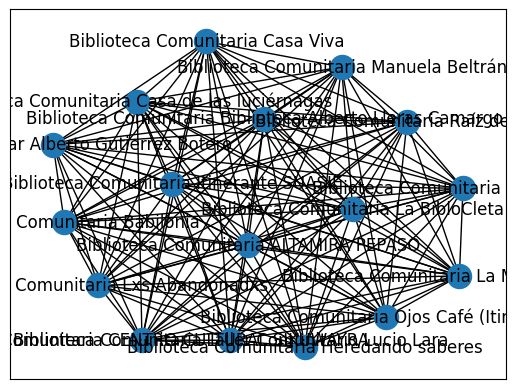

In [3]:
from sandbox.multiplex_network import LayerFactory

# Create layer factory with Gower similarity
factory = LayerFactory(
    similarity_strategy=GowerSimilarity
)

# Create network layer with optimization
network = factory.create_layer(
    master_table=df,
    nodes_name=list(df["BibliotecaNombre"].unique()),
    weighting_strategy='feature_entropy',
    threshold=None,
    nan_strategy='impute'
)
import networkx as nx
nx.draw_networkx(network, with_labels=True)

In [4]:
nx.write_graphml(network, "network.graphml")